In [1]:
import pandas as pd
import ast
import itertools
from collections import Counter
import matplotlib.pyplot as plt
from collections import defaultdict
from utils import calculate_bertscore_f1, get_synonyms, preprocess_text
import numpy as np

In [2]:
gt_labels = pd.read_csv("postprocessed_labels.csv")
gt_labels["most_granular_concept_synonyms"] = gt_labels["most_granular_concept_synonyms"].apply(ast.literal_eval)
merged = list(itertools.chain(*gt_labels["most_granular_concept_synonyms"].map(lambda row: [col[0] for col in row if col]).to_list()))

In [3]:
total_columns = 0
for table in gt_labels["most_granular_concept_synonyms"]:
    for column in table:
        if len(column) > 0:
            total_columns += 1
print(total_columns)

227


In [37]:
def identify_common_by_bertscore(current_word: str, all_words: list[str]) -> str | None:
    bertscores = calculate_bertscore_f1(current_word, all_words)
    max_index = np.argmax(bertscores)
    if bertscores[max_index] > 0.8:
        return all_words[max_index]
    return None

def identify_common_by_nltk(current_word: str, all_words: list[str]) -> str | None:
    print(f"attempting to match {current_word} with {all_words}")
    synonym_sets_of_current_word = get_synonyms(preprocess_text(current_word, True))
    for word in all_words:
        if len(word.split(" ")) != 1:
            continue
        if any(
            synonym_sets_of_current_word.intersection(get_synonyms(preprocess_text(word, True)))
        ):
            return word
    return None
    
def group_common_words(labels: list[str]) -> dict[str, list[str]]:
    tracker = defaultdict(list)
    for label in labels:
        # Initial start
        if len(tracker) == 0:
            tracker[label].append(label)
        else:
            current_root_concepts = list(tracker.keys())
            if len(label.split(" ")) == 1 and (
                most_similar_word := identify_common_by_nltk(label, current_root_concepts)
            ):
                print(f"identify match using nltk {label} with {most_similar_word}")
                tracker[most_similar_word].append(label)
            elif most_similar_word := identify_common_by_bertscore(label, current_root_concepts):
                print(f"identify match using bertscore {label} with {most_similar_word}")
                tracker[most_similar_word].append(label)
            else:
                # Set label as a new root word if
                tracker[label].append(label)
    return tracker

In [38]:
tracker = group_common_words(merged)

attempting to match agent with ['person', 'person function', 'populate place']
attempting to match constituency with ['person', 'person function', 'populate place', 'agent']
attempting to match region with ['person', 'person function', 'populate place', 'agent', 'constituency']
attempting to match person with ['person', 'person function', 'populate place', 'agent', 'constituency', 'region']
identify match using nltk person with person
attempting to match person with ['person', 'person function', 'populate place', 'agent', 'constituency', 'region']
identify match using nltk person with person
attempting to match city with ['person', 'person function', 'populate place', 'agent', 'constituency', 'region']
attempting to match lake with ['person', 'person function', 'populate place', 'agent', 'constituency', 'region', 'city']
attempting to match latitude with ['person', 'person function', 'populate place', 'agent', 'constituency', 'region', 'city', 'lake']
attempting to match lake with ['pe

('thing', 'identifier', 'organisation', 'place', 'work', 'person', 'educational institution', 'time period', 'unemployment', 'populate place', 'academic opportunities', 'date', 'year', 'settlement', 'amount', 'document', 'person function', 'region', 'city', 'person name') (15, 14, 13, 13, 10, 9, 8, 7, 7, 5, 5, 4, 4, 4, 4, 4, 3, 3, 3, 3)


([<matplotlib.axis.XTick at 0x7f27a5060a00>,
 [Text(0, 0, 'thing'),
  Text(1, 0, 'identifier'),
  Text(2, 0, 'organisation'),
  Text(3, 0, 'place'),
  Text(4, 0, 'work'),
  Text(5, 0, 'person'),
  Text(6, 0, 'educational institution'),
  Text(7, 0, 'time period'),
  Text(8, 0, 'unemployment'),
  Text(9, 0, 'populate place'),
  Text(10, 0, 'academic opportunities'),
  Text(11, 0, 'date'),
  Text(12, 0, 'year'),
  Text(13, 0, 'settlement'),
  Text(14, 0, 'amount'),
  Text(15, 0, 'document'),
  Text(16, 0, 'person function'),
  Text(17, 0, 'region'),
  Text(18, 0, 'city'),
  Text(19, 0, 'person name')])

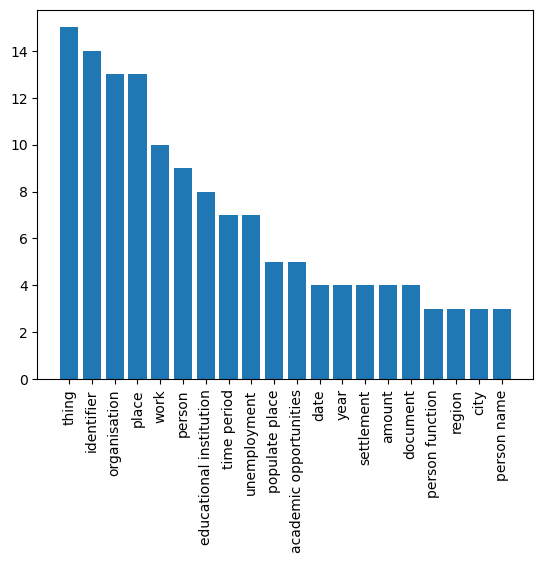

In [39]:
sorted_concept_counts = sorted([(key, len(val)) for key, val in tracker.items()], key=lambda x: -x[1])
keys, values = list(zip(*sorted_concept_counts))
print(keys[:20], values[:20])
ticks = range(20)
plt.bar(ticks,values[:20], align='center')
plt.xticks(ticks, keys[:20], rotation=90)

In [43]:
len(keys)

89

In [42]:
tracker

defaultdict(list,
            {'person': ['person',
              'person',
              'person',
              'person',
              'person',
              'person',
              'person',
              'person',
              'person'],
             'person function': ['person function',
              'person function',
              'person function'],
             'populate place': ['populate place',
              'populate place',
              'populate place',
              'populate place',
              'populate place'],
             'agent': ['agent', 'agent'],
             'constituency': ['constituency', 'constituency'],
             'region': ['region', 'country', 'region'],
             'city': ['city', 'city', 'city'],
             'lake': ['lake', 'lake'],
             'latitude': ['latitude'],
             'lunar longitude': ['lunar longitude'],
             'physical quantity': ['physical quantity', 'physical quantity'],
             'person name': ['person nam